### Problem Statement:
In this notebook we are trying to predict the size of the wildfires with the help of location based features majorly. 
We have implemented multi-class classification algorithms like Logistic Regression, XGBoost. We have implemented Recursive Feature Selection to find the most impactful features for the size of the wildfires. The target is "FIRE_SIZE_CLASS" for this analysis. The size of wildfires is categorized into different classes namely, 'A','B','C','D','E','F','G'. Below is the range that further describes the target: 

FIRE_SIZE_CLASS = Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).

In [14]:
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, recall_score, roc_curve, auc

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [1]:
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import datetime as dt

import sqlite3 as sql
from warnings import filterwarnings
filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sql.connect("FPA_FOD_20170508.sqlite")

### Data Preprocessing

In [3]:
df = pd.read_sql("Select * from fires",con= conn)
df1 = pd.read_sql("Select * from NWCG_UnitIDActive_20170109", con = conn)

In [4]:
df1 = df1.rename(columns = {"UnitId":"NWCG_REPORTING_UNIT_ID"})
df_merged = pd.merge(df,df1,how="left",on="NWCG_REPORTING_UNIT_ID")

In [5]:
df_merged.columns

Index(['OBJECTID_x', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape', 'OBJECTID_y', 'GeographicArea',
       'Gacc', 'WildlandRole', 'UnitType', 'Department', 'Agency', 'Parent',
       'Country', 'State', 'Code', 'Name'],
      dtype='object')

In [6]:
# df['FIRE_SIZE'].head()
df_merged['FIRE_SIZE_CLASS'].unique()

array(['A', 'B', 'G', 'C', 'D', 'F', 'E'], dtype=object)

In [7]:
# df_merged = df_merged.dropna(subset=['DISCOVERY_TIME','CONT_TIME','COUNTY','GeographicArea','Department'])
df_merged.shape

(1880465, 51)

[Text(0, 0, '0.26-9.9'),
 Text(0, 0, '0-2.5'),
 Text(0, 0, '10.0-99.9'),
 Text(0, 0, '100-299'),
 Text(0, 0, '300-999'),
 Text(0, 0, '1000-4999'),
 Text(0, 0, '5000+')]

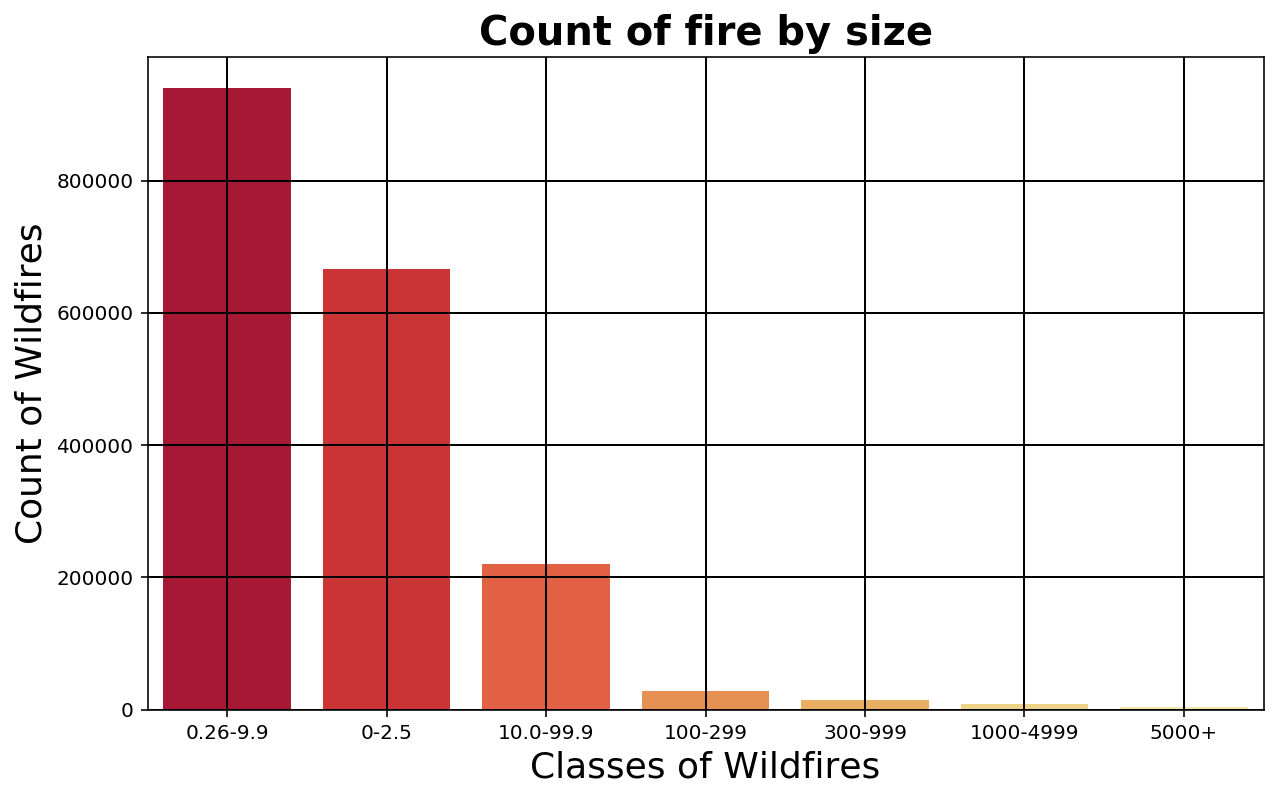

In [15]:
labels = {'B':'0.26-9.9',
          'A':'0-2.5', 
          'C':'10.0-99.9', 
          'D':'100-299', 
          'E':'300-999', 
          'F':'1000-4999', 
          'G': '5000+'}
plt.figure(figsize=(10,6))
ax= sns.countplot(x = 'FIRE_SIZE_CLASS', data = df_merged, palette = 'YlOrRd_r', order = df_merged['FIRE_SIZE_CLASS'].value_counts().index)
ax.set_xlabel('Classes of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_ylabel('Count of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_title('Count of fire by size', fontdict = {'fontsize':20, 'fontweight': 'bold'})
ax.grid(linewidth = 1, color = 'black')
ax.set_xticklabels(labels.values())

In [8]:
df_merged.fillna(method="ffill",inplace=True)

In [9]:
df_merged.fillna(method="bfill",inplace=True)

### One-Hot Encoding

In [58]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880465 entries, 0 to 1880464
Data columns (total 51 columns):
OBJECTID_x                    int64
FOD_ID                        int64
FPA_ID                        object
SOURCE_SYSTEM_TYPE            object
SOURCE_SYSTEM                 object
NWCG_REPORTING_AGENCY         object
NWCG_REPORTING_UNIT_ID        object
NWCG_REPORTING_UNIT_NAME      object
SOURCE_REPORTING_UNIT         object
SOURCE_REPORTING_UNIT_NAME    object
LOCAL_FIRE_REPORT_ID          object
LOCAL_INCIDENT_ID             object
FIRE_CODE                     object
FIRE_NAME                     object
ICS_209_INCIDENT_NUMBER       object
ICS_209_NAME                  object
MTBS_ID                       object
MTBS_FIRE_NAME                object
COMPLEX_NAME                  object
FIRE_YEAR                     int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                 int64
DISCOVERY_TIME                object
STAT_CAUSE_CODE               float64
S

In [10]:
XX= df_merged.drop(['FIRE_SIZE','FIRE_SIZE_CLASS'],axis=1)

In [11]:
X = XX.select_dtypes(include=[object])

# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()


X = X.apply(le.fit_transform)
X.head()

,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,...,Gacc,WildlandRole,UnitType,Department,Agency,Parent,Country,State,Code,Name
0,181593,0,2,5,221,1168,194,3206,108,545111,...,1,2,3,46,24,0,0,4,938,1154
1,181594,0,2,5,174,453,186,1257,550,69422,...,1,2,3,46,24,0,0,4,361,451
2,181598,0,2,5,174,453,186,1257,2908,25384,...,1,2,3,46,24,0,0,4,361,451
3,181604,0,2,5,174,453,186,1257,5148,265332,...,1,2,3,46,24,0,0,4,361,451
4,181605,0,2,5,174,453,186,1257,5559,276714,...,1,2,3,46,24,0,0,4,361,451


In [12]:
# df_merged.info()
X1 =XX.select_dtypes(include=[float])


In [13]:
X3=X.join(X1)
X3=X3.join(df_merged[['FIRE_YEAR','DISCOVERY_DOY']])

In [68]:
X3.corr()

,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,...,DISCOVERY_DATE,STAT_CAUSE_CODE,CONT_DATE,CONT_DOY,LATITUDE,LONGITUDE,OWNER_CODE,OBJECTID_y,FIRE_YEAR,DISCOVERY_DOY
FPA_ID,1.000000,-0.068539,0.058810,-0.301541,0.303262,0.165397,0.375797,0.163282,0.082085,0.013801,...,-0.067323,-0.022013,0.086423,0.179128,0.037103,0.131603,-0.134452,0.295323,-0.065910,-0.038877
SOURCE_SYSTEM_TYPE,-0.068539,1.000000,0.863381,0.883952,0.099419,0.080749,0.279433,-0.000598,-0.099522,0.215726,...,0.046545,0.253468,0.182548,-0.084735,-0.275213,0.494093,0.782505,0.114616,0.052202,-0.152477
SOURCE_SYSTEM,0.058810,0.863381,1.000000,0.774091,0.381385,0.293209,0.470295,0.199162,-0.008058,0.255443,...,0.123771,0.240727,0.272803,0.002878,-0.161340,0.476861,0.650211,0.388267,0.128994,-0.140046
NWCG_REPORTING_AGENCY,-0.301541,0.883952,0.774091,1.000000,0.073470,0.046166,0.154063,-0.026432,-0.103219,0.145021,...,0.033769,0.202863,0.145311,-0.057885,-0.299530,0.429361,0.767025,0.097094,0.038313,-0.122519
NWCG_REPORTING_UNIT_ID,0.303262,0.099419,0.381385,0.073470,1.000000,0.575954,0.802859,0.528191,0.125568,0.114886,...,0.107180,0.064821,0.178990,0.089660,0.113280,0.229803,0.025142,0.971182,0.108686,-0.039707
NWCG_REPORTING_UNIT_NAME,0.165397,0.080749,0.293209,0.046166,0.575954,1.000000,0.525291,0.875814,0.125925,-0.004411,...,0.024372,0.049870,0.053098,-0.003360,0.098085,-0.066389,0.034102,0.564882,0.024272,0.002896
SOURCE_REPORTING_UNIT,0.375797,0.279433,0.470295,0.154063,0.802859,0.525291,1.000000,0.459696,0.115412,0.173023,...,0.136229,0.186015,0.176959,0.009488,-0.021165,0.232796,0.149252,0.732821,0.138824,-0.068889
SOURCE_REPORTING_UNIT_NAME,0.163282,-0.000598,0.199162,-0.026432,0.528191,0.875814,0.459696,1.000000,0.094685,0.009695,...,-0.016356,0.036028,0.022671,-0.049001,0.140510,-0.020739,-0.047879,0.532705,-0.016323,-0.001026
LOCAL_FIRE_REPORT_ID,0.082085,-0.099522,-0.008058,-0.103219,0.125568,0.125925,0.115412,0.094685,1.000000,-0.207588,...,0.237175,-0.015565,0.324802,-0.071864,-0.021144,-0.063227,-0.005099,0.096149,0.237477,-0.005965
LOCAL_INCIDENT_ID,0.013801,0.215726,0.255443,0.145021,0.114886,-0.004411,0.173023,0.009695,-0.207588,1.000000,...,0.152462,0.133669,0.128341,-0.015056,0.071201,0.219545,0.121118,0.106266,0.153442,-0.024997


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import copy

X4=X3[['FIRE_YEAR','DISCOVERY_DATE','DISCOVERY_DOY','DISCOVERY_TIME','STAT_CAUSE_CODE',
      'CONT_DATE',
      'CONT_TIME',
      'LATITUDE',
      'LONGITUDE',
      'OWNER_CODE',
      'OWNER_DESCR',
      'STATE',
      'COUNTY',
      'FIPS_CODE',
      'GeographicArea',
      'Gacc', 'WildlandRole', 
      'UnitType', 
      'Department']]
y=df_merged[['FIRE_SIZE_CLASS']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X4)

### Logistic Regression

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, y,test_size=0.3, random_state=0)
lm=LogisticRegression(C=10, random_state=0)
lm.fit(X_train,y_train)

C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
from sklearn.metrics import accuracy_score
pred = lm.predict(X_test)
accuracy_score(y_test,pred)


0.5787588187329387

### XGBOOST

In [72]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X4 , y,test_size=0.3, random_state=0)

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=2000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb.fit(X_train, y_train)


C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=4, objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)

In [73]:
pred_xgb = xgb.predict(X_test)

In [74]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred_xgb)

0.6580299216506541

#### Parameter Tuning over 1.88 million rows

In [ ]:
from xgboost import XGBClassifier

X_train1, X_test1, y_train1, y_test1 = train_test_split(X4 , y,test_size=0.3, random_state=0)

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=15,
    max_delta_step=2,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb1.fit(X_train1, y_train1)


C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred_xgb1 = xgb1.predict(X_test)
accuracy_score(y_test,pred_xgb1)

### XGBOOST using  a fraction of dataset

In [13]:
import copy
df1 = copy.deepcopy(df_merged)
df1.sample(frac=0.1, replace=True, random_state=1)


X2=df_merged[['FIRE_YEAR','DISCOVERY_DATE','DISCOVERY_DOY','DISCOVERY_TIME','STAT_CAUSE_CODE',
      'CONT_DATE',
      'CONT_TIME',
      'LATITUDE',
      'LONGITUDE',
      'OWNER_CODE',
      'OWNER_DESCR',
      'STATE',
      'COUNTY','FIPS_CODE','GeographicArea','Gacc', 'WildlandRole', 'UnitType', 'Department']]
y2=df_merged[['FIRE_SIZE_CLASS']]



X_2 = X2.select_dtypes(include=[object])

le = preprocessing.LabelEncoder()


X_2 = X2.apply(le.fit_transform)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y2,test_size=0.3, random_state=0)

In [14]:
from xgboost import XGBClassifier

xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb2.fit(X_train2, y_train2)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)

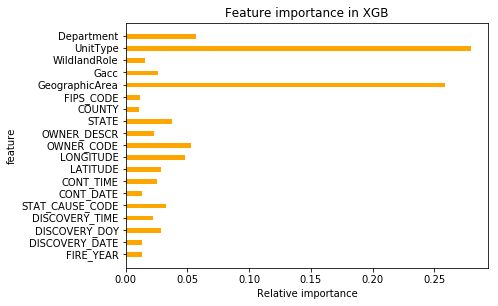

<Figure size 360x360 with 0 Axes>

In [46]:
Y = xgb2.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(Y)) # the x locations for the groups
ax.barh(ind, Y, width, color="orange")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(X.columns, minor=False)
plt.title('Feature importance in XGB')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [15]:
pred_xgb2 = xgb2.predict(X_test2)

In [16]:
accuracy_score(y_test2,pred_xgb2)

0.6910118274663952

In [39]:
cd = pd.DataFrame(pred_xgb2,columns=['FIRE_SIZE_CLASS'])
cd.head()

,FIRE_SIZE_CLASS
0,A
1,B
2,A
3,B
4,B


In [41]:
cd_merge = X_test2.join(cd)

[Text(0, 0, '0.26-9.9'),
 Text(0, 0, '0-2.5'),
 Text(0, 0, '10.0-99.9'),
 Text(0, 0, '100-299'),
 Text(0, 0, '300-999'),
 Text(0, 0, '1000-4999'),
 Text(0, 0, '5000+')]

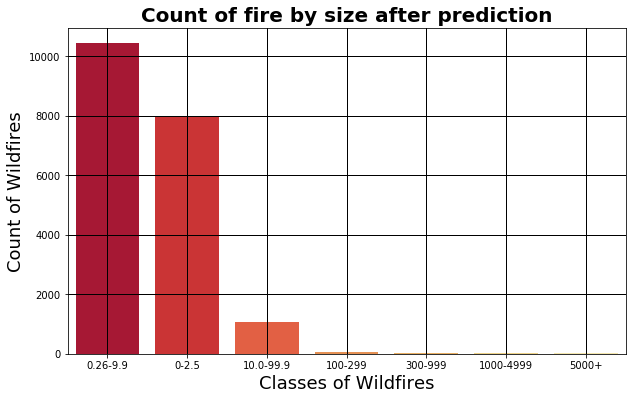

In [43]:
labels = {'B':'0.26-9.9',
          'A':'0-2.5', 
          'C':'10.0-99.9', 
          'D':'100-299', 
          'E':'300-999', 
          'F':'1000-4999', 
          'G': '5000+'}
plt.figure(figsize=(10,6))
ax= sns.countplot(x = 'FIRE_SIZE_CLASS', data = cd_merge, palette = 'YlOrRd_r', order = cd_merge['FIRE_SIZE_CLASS'].value_counts().index)
ax.set_xlabel('Classes of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_ylabel('Count of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_title('Count of fire by size after prediction', fontdict = {'fontsize':20, 'fontweight': 'bold'})
ax.grid(linewidth = 1, color = 'black')
ax.set_xticklabels(labels.values())

### Recursive Feature Selection

In [26]:
from sklearn.feature_selection import RFE
model = XGBClassifier()
rfe = RFE(model, 3)
fit = rfe.fit(X_2, y2)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 3
Selected Features: [False False False False False False False False  True False False False
 False False  True False False  True False]
Feature Ranking: [17 11  2  7  6 14  8  4  1  9 12  5 16 15  1 10 13  1  3]


In [17]:
X5=X3[[
      'LONGITUDE',
     
      'GeographicArea',
      
      'UnitType', 
      ]]
y=df_merged[['FIRE_SIZE_CLASS']]

In [19]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X5, y,test_size=0.3, random_state=101)

In [20]:
from xgboost import XGBClassifier

xgb_rfe = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.6,
 colsample_bytree=0.6,
 objective= 'multi:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb_rfe.fit(X_train_rfe, y_train_rfe)

C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Vrinda Sharma\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.6, verbosity=1)

In [21]:
pred_xgb_rfe = xgb_rfe.predict(X_test_rfe)

In [24]:
accuracy_score(y_test_rfe,pred_xgb_rfe)

0.5981033076895806

[Text(0, 0, '0.26-9.9'),
 Text(0, 0, '0-2.5'),
 Text(0, 0, '10.0-99.9'),
 Text(0, 0, '100-299'),
 Text(0, 0, '300-999'),
 Text(0, 0, '1000-4999'),
 Text(0, 0, '5000+')]

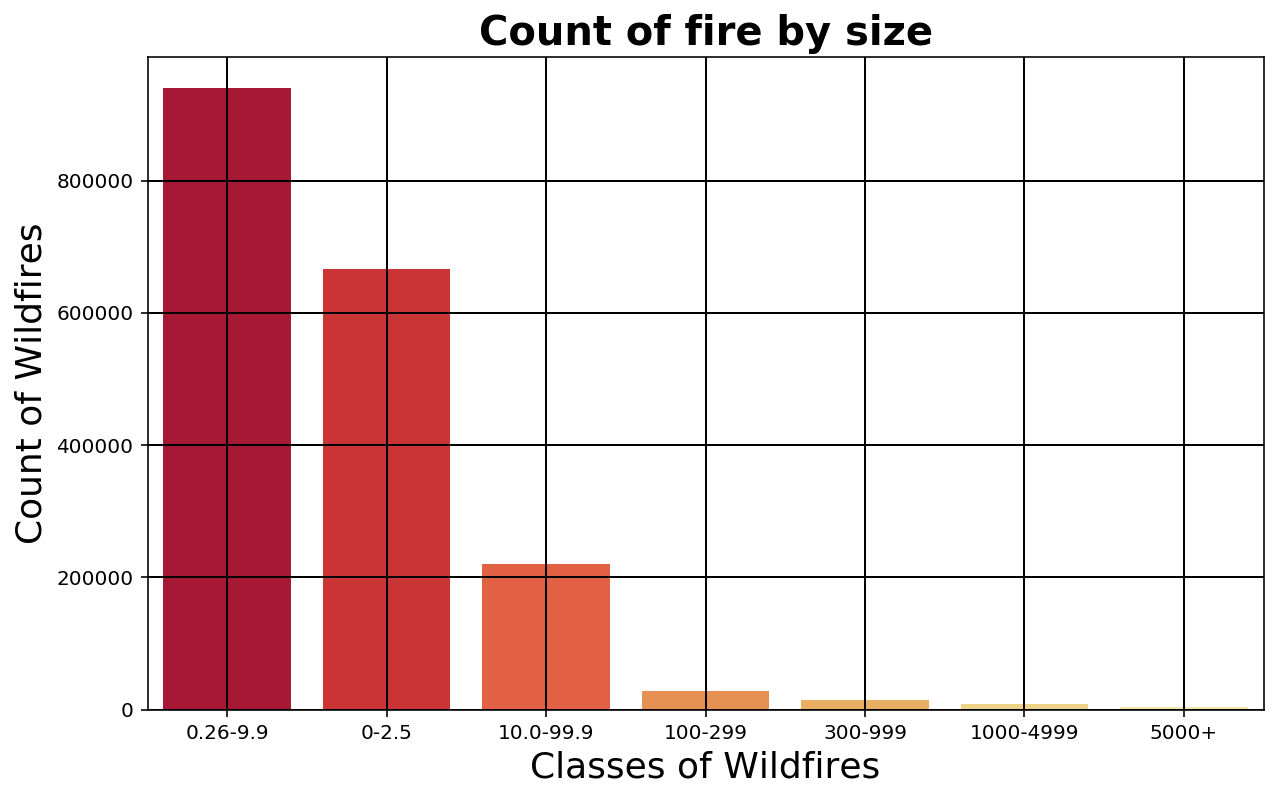

In [17]:
labels = {'B':'0.26-9.9',
          'A':'0-2.5', 
          'C':'10.0-99.9', 
          'D':'100-299', 
          'E':'300-999', 
          'F':'1000-4999', 
          'G': '5000+'}
plt.figure(figsize=(10,6))
ax= sns.countplot(x = 'FIRE_SIZE_CLASS', data = df_merged, palette = 'YlOrRd_r', order = df_merged['FIRE_SIZE_CLASS'].value_counts().index)
ax.set_xlabel('Classes of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_ylabel('Count of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_title('Count of fire by size', fontdict = {'fontsize':20, 'fontweight': 'bold'})
ax.grid(linewidth = 1, color = 'black')
ax.set_xticklabels(labels.values())